# Chose the Best Model 

## Load the Data Set

In [1]:
import nltk
import json
import gensim
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from sklearn import preprocessing

def get_df(oos = True, domains = False) :
    with open('data_full.json') as json_file: 
        data_dict = json.load(json_file) 

    train_data = data_dict['train']
    val_data = data_dict['val']
    test_data = data_dict['test']

    oos_train = data_dict['oos_train']
    oos_val = data_dict['oos_val']
    oos_test = data_dict['oos_test']


    train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
    val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
    test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

    train_oos_df = pd.DataFrame(oos_train,columns=['query','intent'])
    val_oos_df = pd.DataFrame(oos_val,columns=['query','intent'])
    test_oos_df = pd.DataFrame(oos_test,columns=['query','intent'])

    if oos :
        # Concatenate dataframes to consider oos as a specific intent
        train_df = pd.concat([train_df,train_oos_df])
        val_df = pd.concat([val_df,val_oos_df])
        test_df = pd.concat([test_df,test_oos_df])
    
    train_df =pd.concat([train_df,val_df])

    if domains:
        with open('domains.json') as json_file:
            domain_dict = json.load(json_file)
        inv_domain_dict = {}
        for domainKey in domain_dict.keys():
            for intent in domain_dict[domainKey]:
                inv_domain_dict[intent] = domainKey
        if oos:
            inv_domain_dict['oos']='oos'
        train_df['domain'] = train_df.apply(lambda row: inv_domain_dict[row['intent']],axis=1)
        test_df['domain'] = test_df.apply(lambda row: inv_domain_dict[row['intent']],axis=1)
    
    return train_df, test_df


df_train, df_test = get_df(oos=False,domains=True)
print(len(df_train))
print(len(df_test))


18000
4500


## Pre processing 

In [2]:
# Preprocessing

def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

In [3]:
# Apply preprocessing
df_train["query_clean"] = df_train["query"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
df_test["query_clean"] = df_test["query"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))

In [4]:
def corpus_as_lst(corpus):
   ## create list of lists of unigrams
   lst_corpus = []
   for string in corpus:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
      lst_corpus.append(lst_grams)
   return lst_corpus

# Prepare the corpus to be trained by Word2Vec
train_corpus = corpus_as_lst(df_train['query_clean'])

## Trainging word embeddings
Train a word embedding with the vocalburay of the queries in the dataset.

In [5]:
# Training word embeddings
wc_model = gensim.models.word2vec.Word2Vec(train_corpus, vector_size=300,   window=8, min_count=1, sg=1, epochs=30)


In [6]:
def text_to_mean_vector(embeddings, text):
    tokens = text.split()
    vec = []
    for i in range(len(tokens)):
        try:
            vec.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
    if(len(vec)!=0):
        return [sum([row[j] for row in vec]) / len(vec) for j in range(len(vec[0]))]
    else : 
        return []
    
def get_word_embdeddings(lst_corpus, model):
    embeddings_corpus = []
    for c in lst_corpus:
        mean_vec = text_to_mean_vector(model.wv, c)
        if(len(mean_vec)!=0):
            embeddings_corpus.append(mean_vec)
        else:
            embeddings_corpus.append(np.zeros(model.wv.vector_size,))
    return np.array(embeddings_corpus)

In [7]:
# Extracting word embeddings
X_train_we = get_word_embdeddings(df_train['query_clean'], wc_model)
X_test_we = get_word_embdeddings(df_test['query_clean'], wc_model)



(18000, 300)
(4500, 300)


### Train the Models 
Train all the models chosed and print his respectives results.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


In [9]:
models = [
    LogisticRegression(multi_class='multinomial', max_iter=300),
    SVC(probability=True),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=2, random_state=0),
    GaussianNB(),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
]
model_names = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "         Random Forest",
    "  Gaussian Naive Bayes", 
    "Multi-Layer Perceptron"
]


In [23]:
def train_model(model, X_train, df_train, df_test, domains = False):
    y_train = (df_train['domain'].values) if domains else (df_train['intent'].values)
    return model.fit(X_train, y_train)

def predic_of_model(model_fited, X_test, domains = False):
    y_test = df_test['domain'].values if domains else df_test['intent'].values
    y_pred = model_fited.predict(X_test)
   
    return y_pred, y_test, X_test
        

In [24]:
fited_models = []
for model, name in zip(models, model_names):
    fited_model = train_model(model, X_train_we, df_train, df_test, domains = False)
    print("finished train model: ", name)
    fited_models.append(fited_model)

print(fited_models)

finished train model
finished train model
finished train model
finished train model
finished train model
finished train model
[LogisticRegression(max_iter=300, multi_class='multinomial'), SVC(probability=True), DecisionTreeClassifier(random_state=0), RandomForestClassifier(max_depth=2, random_state=0), GaussianNB(), MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')]


### Report the model's results 

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
def printReport(model, name, X_test, y_test, y_pred):
    print("################# " + name.upper() + '#################')
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels= model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(100,100))
    disp.plot(ax=ax)
    plt.show()
    # score
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))
    # report
    print(classification_report(y_test, y_pred))

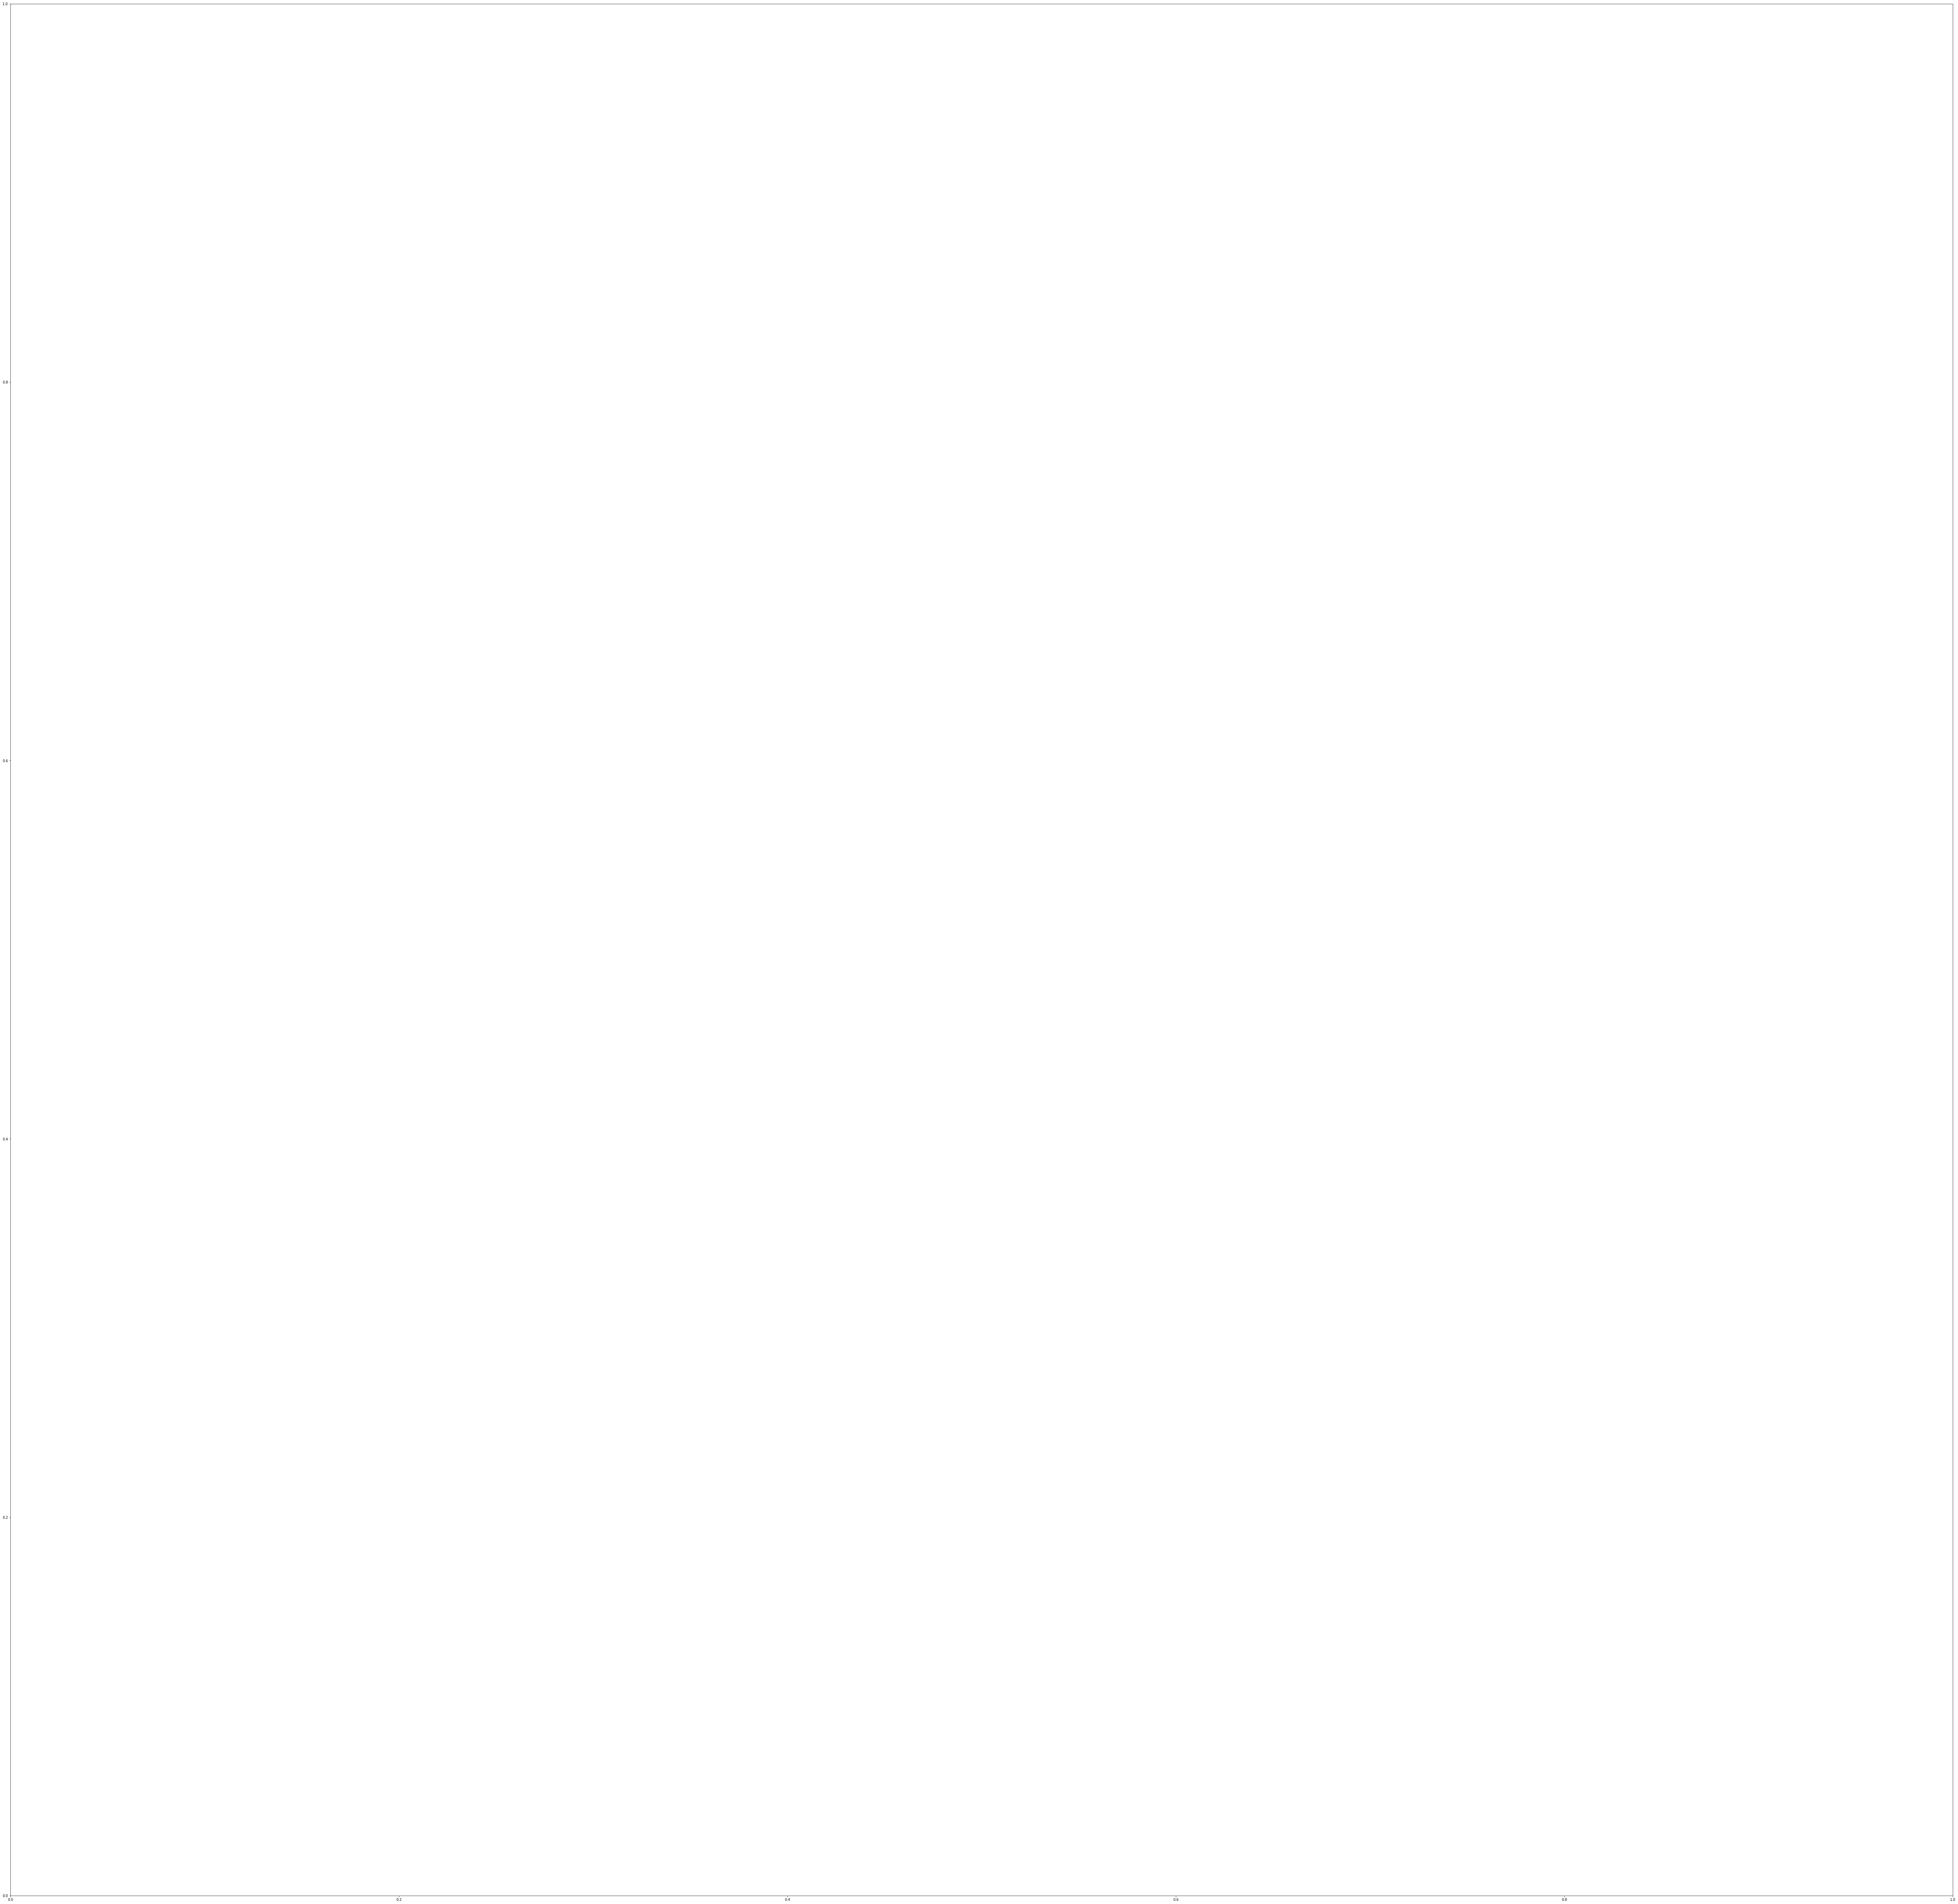

#####################     LOGISTIC REGRESSION  #####################
   Logistic Regression: 89.2889%
[[26  0  0 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  3  0]
 [ 0  0  0 ...  1 28  0]
 [ 0  0  0 ...  0  0 15]]
                           precision    recall  f1-score   support

      accept_reservations       0.96      0.87      0.91        30
          account_blocked       0.81      0.87      0.84        30
                    alarm       1.00      0.97      0.98        30
       application_status       0.88      1.00      0.94        30
                      apr       0.97      0.93      0.95        30
            are_you_a_bot       1.00      0.97      0.98        30
                  balance       0.80      0.93      0.86        30
             bill_balance       0.88      0.70      0.78        30
                 bill_due       0.82      0.90      0.86        30
              book_flight       0.97      1.00      0.98        30
    

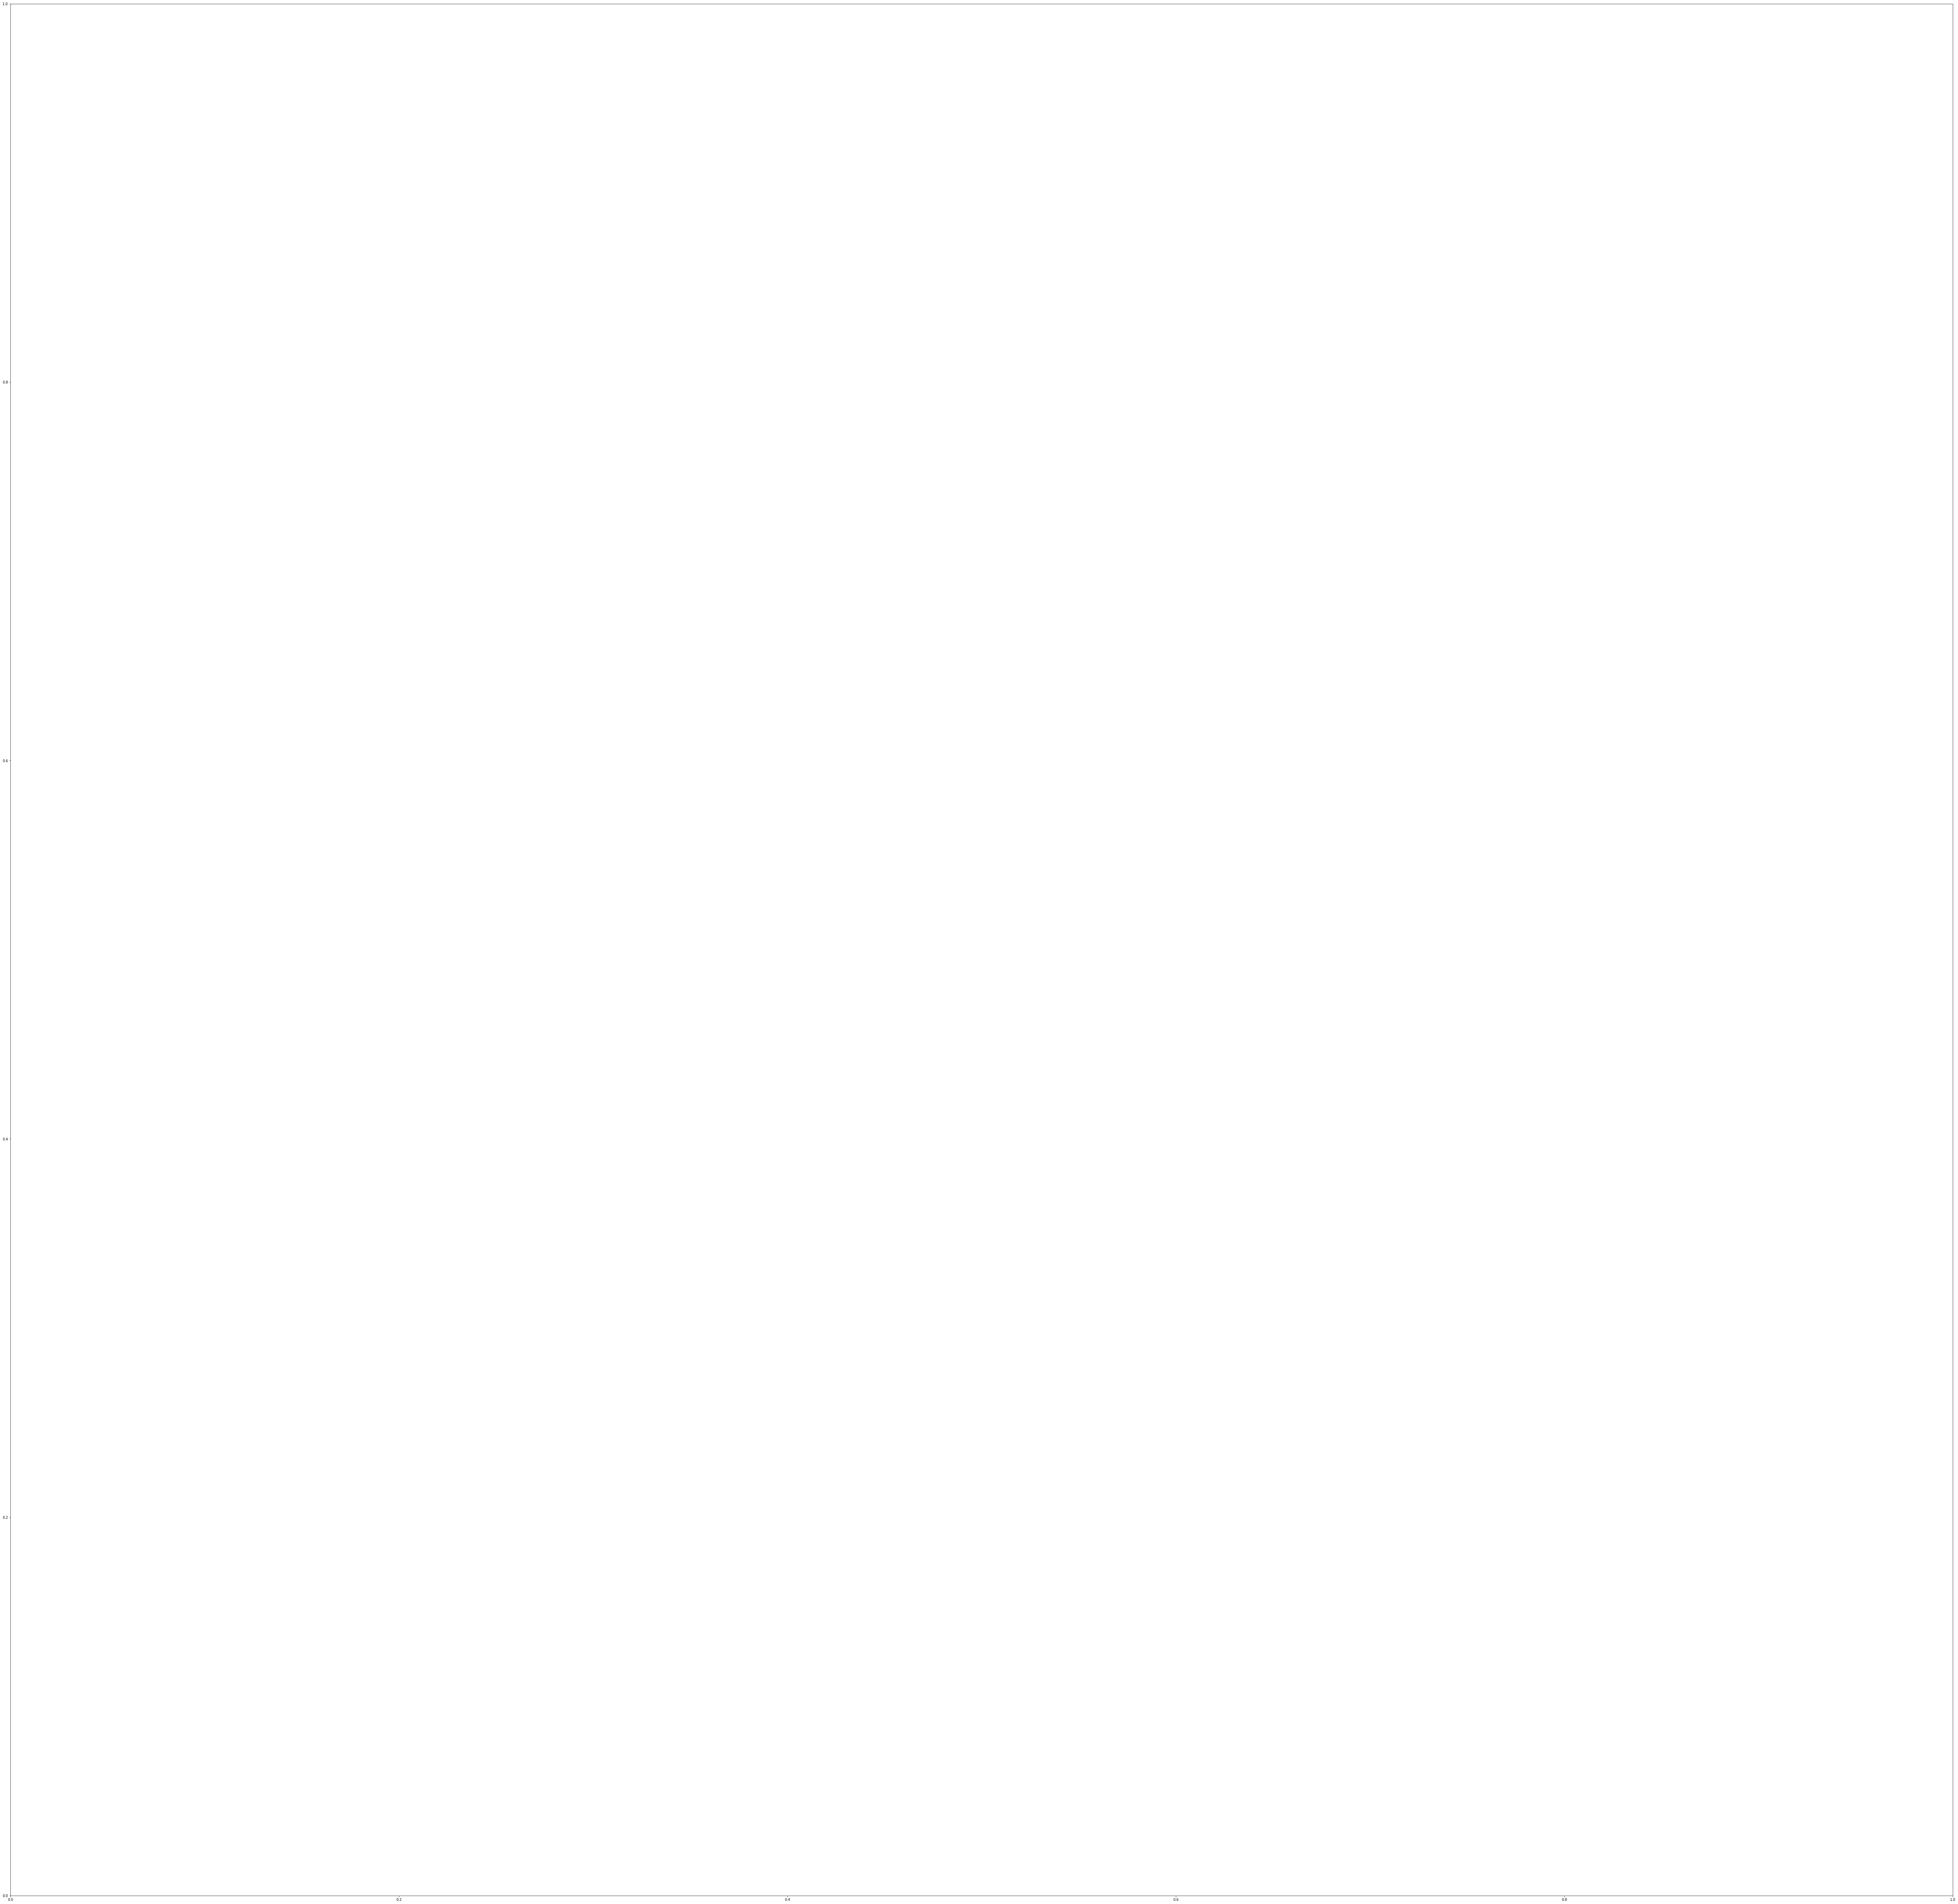

#####################  SUPPORT VECTOR MACHINE  #####################


KeyboardInterrupt: 

In [43]:
for fited_model, name in zip(models, model_names):
    y_pred, y_test, X_test = predic_of_model(fited_model, domains = False)
    printReport(fited_model, name, X_test, y_test, y_pred)
    

### External exploration
The class(intent) with the worst result using Logist Regration is "yes", "goodbye" lets check what it is going on

In [ ]:
import os

#query = input("Enter query: ")
query = "Set my alarm to 6 am"
# preprocess
query = utils_preprocess_text(query)

# vectorize the review
V2 = vectorizer.transform([query]).toarray()
V = get_word_embdeddings( query, wc_model)

print(query)
print(V.shape)
print(V)
clf = fited_models[0];
print(clf)
print(clf.predict(V2));
print(clf.predict(V));
print(clf.predict(query.split()));
print(clf.predict(V)[0]);

### Now Using raw text

In [63]:
###### no word embedings
fited_models = []
df_train, df_test = get_df(oos=False,domains=True)
train_corpus = corpus_as_lst(df_train['query'])
txt = [" ".join(x) for x in train_corpus]
#print(" ".join(txt))
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(txt).toarray()
print("HERE", "vectorize done")
for model, name in zip(models, model_names):
    fited_model = train_model(model, X_train, df_train, df_test, domains = False)
    print("finished train model: ", name)
    fited_models.append(fited_model)

print(fited_models)

HERE vectorize done


KeyboardInterrupt: 

### Chossing the best model
Run all fit all the models selected if difrent paramters for chose the best model with the best score. 

In [ ]:
#Chossing the best model
from sklearn.model_selection import GridSearchCV
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto', max_iter=300),
        'params': {
            'solver': ['sag', 'saga','newton-cg', 'lbfgs'],
            'C': [1,5,10]
        }
    },
    'Multi-Layer Perceptron': {
        'model': MLPClassifier(),
        'params' : {
            'gamma': ['scale', 'auto'],
            'C': [1, 10, 20],
            'kernel': ['sigmoid', 'precomputed'],
            'cache_size':(200)
        }
    }
    
    
}

In [ ]:
scores = []
classByDomain = False

for model_name, mp in model_params.items():
    if classByDomain:
        y_train = df_train['domain'].values
        y_test = df_test['domain'].values
    else:
        y_train = df_train['intent'].values
        y_test = df_test['intent'].values
        
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [ ]:
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df
